In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

from skimage import color, feature, exposure

import random
import cv2

import shutil
import Augmentor
import os

from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

import torch.nn.functional as F
import torchvision.transforms.functional as FT

In [117]:
resize_size = 300
batch_size = 45

In [118]:
# transformations
transform_train = transforms.Compose([
    transforms.Resize((resize_size,resize_size)),
    transforms.ToTensor(),
    #transforms.ToPILImage(), # the transform usually work with PIL images
    # mean(r,g,b) and s.d(r,g,b) ; normal --> [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [119]:
data_root = 'traindata'
custom_dataset = ImageFolder(root=data_root, transform=transforms.ToTensor())

size = len(custom_dataset)

# specify classes
classes = ('cherry','strawberry', 'tomato')

## Step 1 - EDA

In [120]:
## check the number of samples in each set
print(f'Total images: {size}')
    
## display an example image from the dataset
print('------------------------')    
print('Display an example image from the dataset:')    

img,label = custom_dataset[0]

print(f'image shape: {img.shape}')
print(f'image label: {label}')

Total images: 6300
------------------------
Display an example image from the dataset:
image shape: torch.Size([3, 300, 300])
image label: 0


**1. Check Class Distribution**

Question: is there any class dominating?

------------------------
Class distribution:
cherry: 2100 samples
strawberry: 2100 samples
tomato: 2100 samples


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


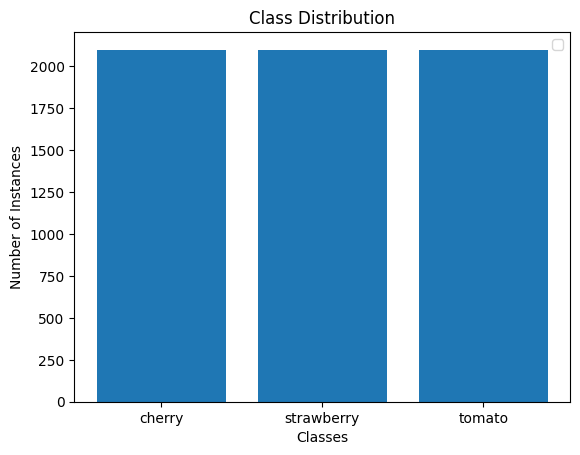

In [121]:
def show_class_distribution(dataset, title = 'Class Distribution'):
    ## check the distribution of classes in the dataset
    class_counts = {classes[i]:0 for i in range(len(classes))}
    for _, label in dataset:
        class_counts[classes[label]] +=1

    print('------------------------')    
    print('Class distribution:')    
    for cls, count in class_counts.items():
        print(f'{cls}: {count} samples')

    ## Visualization
    class_counts = [len([1 for _, label in dataset if label == i]) for i in range(len(classes))]

    plt.bar(classes, class_counts)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Instances')
    plt.legend()
    plt.show()
    
show_class_distribution(custom_dataset)    

**2. Image Size and Resolution**

Question: Are all images of the same size and resolution?

Solution: if not, standardization

In [122]:
import torch

# Get sizes of all images
image_sizes = [img.size() for img, _ in custom_dataset]

# Remove duplicates
unique_sizes = set(image_sizes)

# Print a summary
print(f"Number of Unique Image Sizes: {len(unique_sizes)}")

# Find min and max sizes
max_size = max(image_sizes, key=lambda size: size[2])  # Assuming you want to find the maximum based on width
print("Max Size:", max_size)

min_size = min(image_sizes, key=lambda size: size[1])  # Assuming you want to find the minimum based on height
print("Min Size:", min_size)

print("Example Unique Sizes:")
for size in list(unique_sizes)[:5]:  # Display the first 5 unique sizes
    print(size)

Number of Unique Image Sizes: 35
Max Size: torch.Size([3, 900, 870])
Min Size: torch.Size([3, 138, 366])
Example Unique Sizes:
torch.Size([3, 193, 261])
torch.Size([3, 236, 214])
torch.Size([3, 228, 221])
torch.Size([3, 229, 220])
torch.Size([3, 279, 181])


**3. Visual Inspection**

Question: from a peek at a few images from each class, do they seem clear, or are there any anomalies?

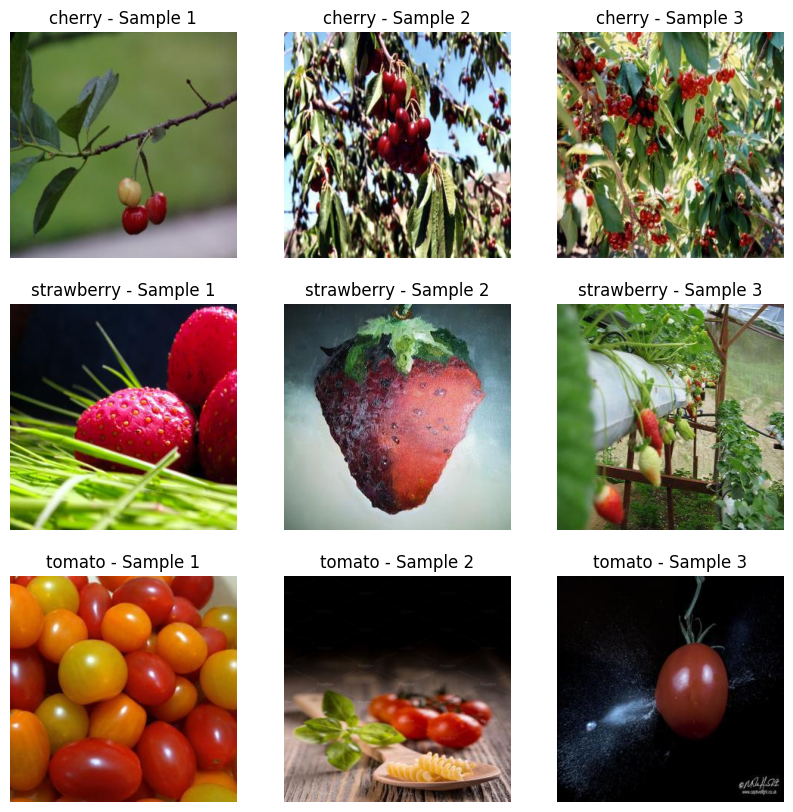

In [125]:
import torchvision.transforms.functional as TF

# Display a few images from each class
fig, axs = plt.subplots(len(classes), 3, figsize=(10, 10))

for i, class_name in enumerate(classes):
    images = [img for img, label in custom_dataset if label == i][:3]
    for j, img in enumerate(images):
        # Convert the PyTorch Tensor to a NumPy array
        img_np = FT.to_pil_image(img)
        
        axs[i, j].imshow(img_np) 
        axs[i, j].axis('off')
        axs[i, j].set_title(f'{class_name} - Sample {j+1}')

plt.show()

**4. Color Distribution**

Question: are there specific color patterns for each class?

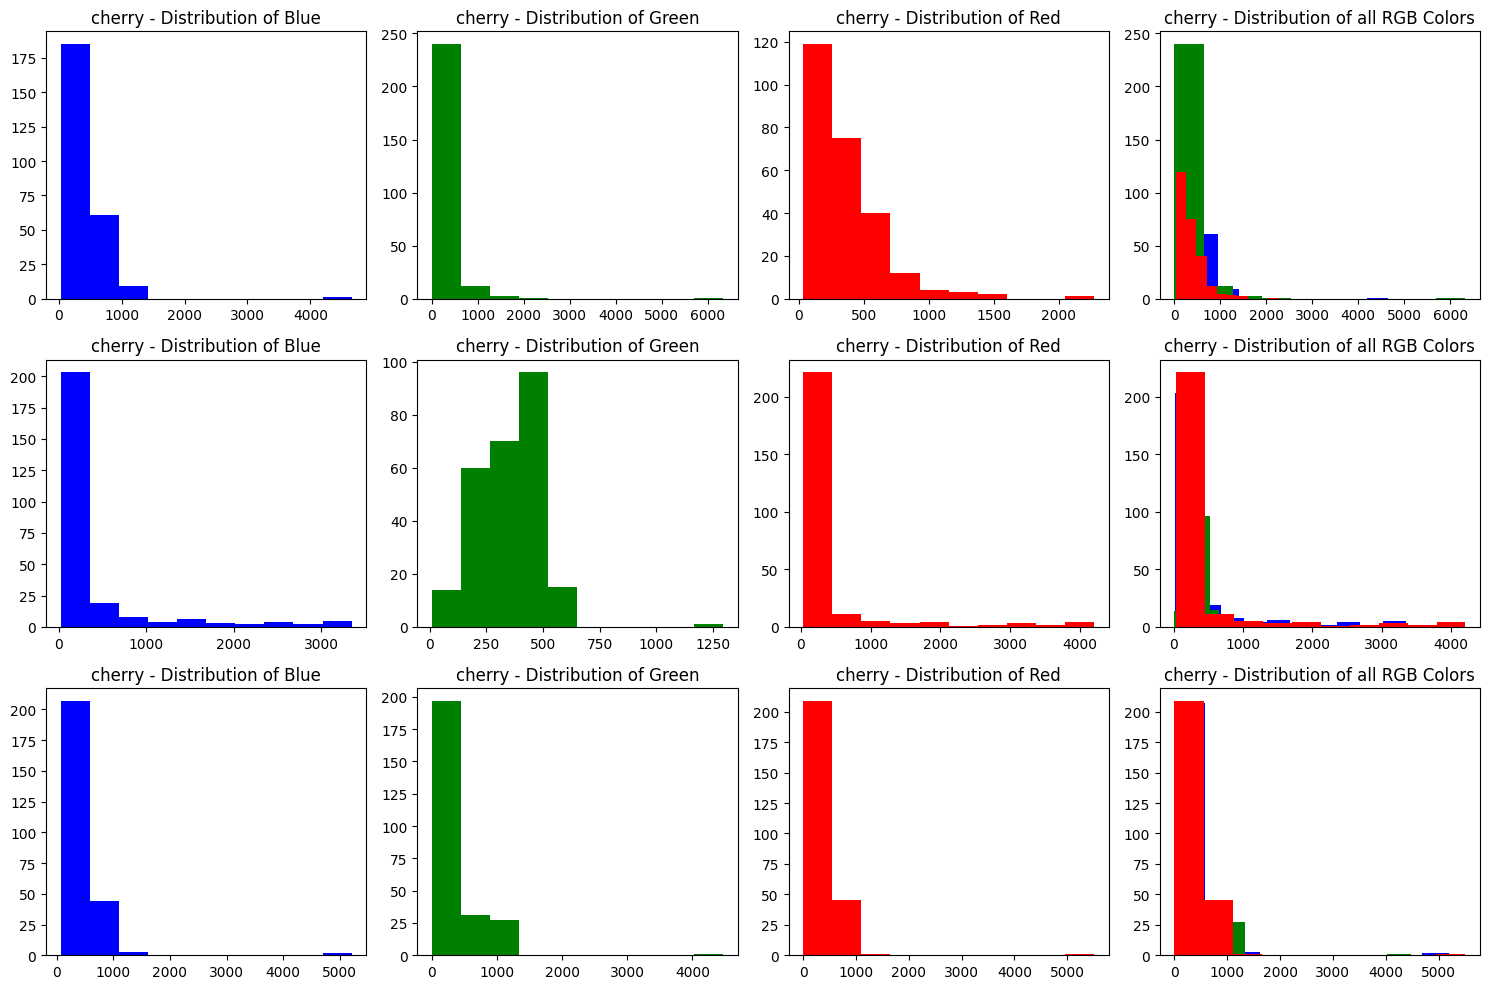

In [126]:
import cv2
import matplotlib.pyplot as plt
import random

def plot_color_distribution(imageObj, class_index, class_name):
    blue_color = cv2.calcHist([imageObj], [0], None, [256], [0, 256]) 
    red_color = cv2.calcHist([imageObj], [1], None, [256], [0, 256]) 
    green_color = cv2.calcHist([imageObj], [2], None, [256], [0, 256]) 
    
    locations = {"0":[1,2,3,4], "1":[5,6,7,8], "2":[9,10,11,12]}
    loc = locations[str(class_index)]
    
    # Separate Histograms for each color 
    plt.subplot(3, 4, loc[0]) 
    plt.title(f"{class_name} - Distribution of Blue") 
    plt.hist(blue_color, color="blue") 

    plt.subplot(3, 4, loc[1]) 
    plt.title(f"{class_name} - Distribution of Green") 
    plt.hist(green_color, color="green") 

    plt.subplot(3, 4, loc[2]) 
    plt.title(f"{class_name} - Distribution of Red") 
    plt.hist(red_color, color="red")
    
    plt.subplot(3, 4, loc[3]) 
    plt.title(f"{class_name} - Distribution of all RGB Colors") 
    plt.hist(blue_color, color="blue") 
    plt.hist(green_color, color="green") 
    plt.hist(red_color, color="red") 

# Set the figure size using figsize
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Choose a random image for each class
images = [(img_path, label) for img_path, label in custom_dataset.imgs if label == 0]
class_name = classes[0]
for index in range(0,3):
    img_path, img = random.choice(images)
    image = cv2.imread(img_path)
    plot_color_distribution(image, index, class_name)

plt.tight_layout()
plt.show()

In [ ]:
# Set the figure size using figsize
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Choose a random image for each class
images = [(img_path, label) for img_path, label in custom_dataset.imgs if label == 1]
class_name = classes[1]
for index in range(0,3):
    img_path, img = random.choice(images)
    image = cv2.imread(img_path)
    plot_color_distribution(image, index, class_name)

plt.tight_layout()
plt.show()

In [ ]:
# Set the figure size using figsize
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Choose a random image for each class
images = [(img_path, label) for img_path, label in custom_dataset.imgs if label == 2]
class_name = classes[2]
for index in range(0,3):
    img_path, img = random.choice(images)
    image = cv2.imread(img_path)
    plot_color_distribution(image, index, class_name)

plt.tight_layout()
plt.show()

Insights: it is possible have noisy in images as some samples above shows the (right) skewed distributions. 

**5. Noise check**

Number of noisy images: 32


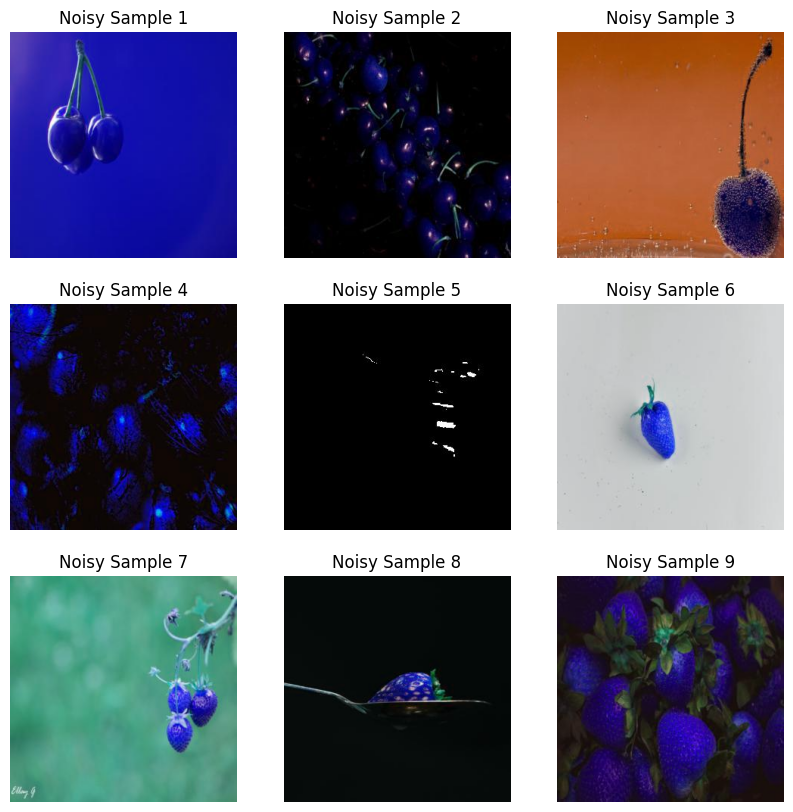

In [129]:
def is_noisy(img_path):
    # Read the image using OpenCV
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate the standard deviation of pixel values
    std_dev = np.std(gray_img)
    
    # Set a threshold
    threshold = 20

    # Return True if the image is noisy, False otherwise
    return std_dev < threshold

def detect_noisy_images(dataset):
    noisy_image_count = 0
    noisy_images = []
    non_noisy_images = []

    for img_path, class_ in dataset.imgs:
        # Check if the image is noisy
        if is_noisy(img_path):
            noisy_image_count += 1
            noisy_images.append((img_path, class_))
        else:
            non_noisy_images.append((img_path, class_))

    print(f'Number of noisy images: {noisy_image_count}')

    # Display a few images from each class
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    i, j = 0, 0
    count = 1
    for img_path, class_ in noisy_images:
        img = cv2.imread(img_path)
        # Convert the PyTorch Tensor to a NumPy array
        img_np = FT.to_pil_image(img)

        axs[i, j].imshow(img_np) 
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Noisy Sample {count}')
        count += 1

        j += 1
        if j==3:
            i += 1
            j = 0
        if i==3:
            break
    plt.show()
    
    return noisy_image_count, noisy_images, non_noisy_images

noisy_image_count, noisy_images, non_noisy_images = detect_noisy_images(custom_dataset)

Insight: the TV Chambolle denoising algorithm seems to give good results after many tries. It would be the most relevant candidate to choose for the noisy removal

## Step 2 - Pre-processing

**1. Remove Noisy Images**

Do this to have the model generalize well.

In [130]:
custom_dataset.transform = transform_train

print(f'Number of images before removing noisy images: {len(custom_dataset.imgs)}')
custom_dataset.imgs = non_noisy_images
print(f'Number of images after removing noisy images: {len(custom_dataset.imgs)}')


Number of images before removing noisy images: 6300
Number of images after removing noisy images: 6268


**2. Prepare Data and Train Classifier**

In [131]:
def prepare_train_test_data(dataset):
    size = len(dataset)
    train_size = int(0.8 * size)
    test_size = size - train_size

    # split the dataset into train and test
    train, test = random_split(
        dataset, [train_size, test_size]
    )

    # DataLoader
    train_loader = DataLoader(train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test, batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train, test, train_loader, test_loader

In [132]:
train, test, train_loader, test_loader = prepare_train_test_data(custom_dataset)

small_train, small_test, small_train_loader, small_test_loader = prepare_train_test_data(test_loader.dataset.dataset)

------------------------
Class distribution:
cherry: 1201 samples
strawberry: 1200 samples
tomato: 1199 samples


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


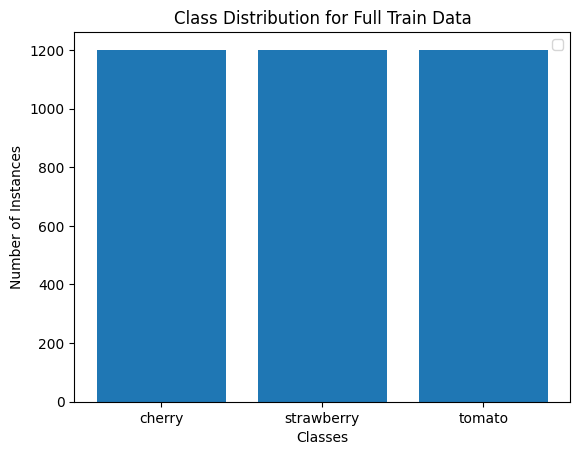

------------------------
Class distribution:
cherry: 299 samples
strawberry: 300 samples
tomato: 301 samples


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


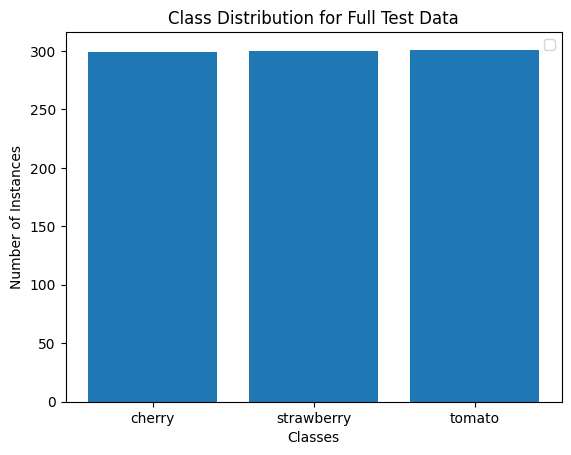

In [64]:
show_class_distribution(train, 'Class Distribution for Full Train Data')    
show_class_distribution(test, 'Class Distribution for Full Test Data')    

------------------------
Class distribution:
cherry: 1187 samples
strawberry: 1209 samples
tomato: 1204 samples


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


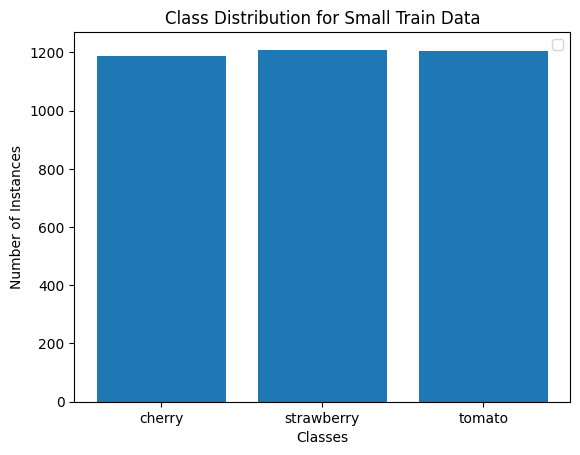

------------------------
Class distribution:
cherry: 313 samples
strawberry: 291 samples
tomato: 296 samples


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


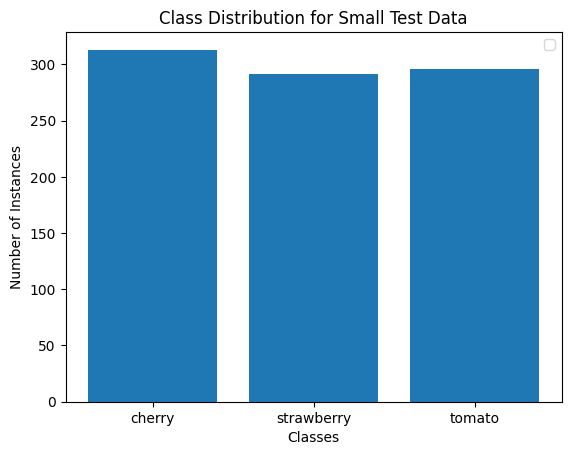

In [65]:
show_class_distribution(small_train, 'Class Distribution for Small Train Data')    
show_class_distribution(small_test, 'Class Distribution for Small Test Data')    

**3. Prepare the method to train and predict data**

In [133]:
def train_eval(model, train_loader, test_loader, loss_fn, optimizer, epochs = 10):
    # Create lists to store loss and accuracy for each epoch for both train and test sets
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []

    # Training and evaluation loop
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss_train = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item()
            correct_train += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss_train = running_loss_train / len(train_loader)
        epoch_accuracy_train = 100 * correct_train / total_train
        train_loss_list.append(epoch_loss_train)
        train_accuracy_list.append(epoch_accuracy_train)

        # Evaluation on Test set
        model.eval()
        running_loss_test = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                running_loss_test += loss.item()
                correct_test += (torch.argmax(outputs, dim=1) == labels).sum().item()
                total_test += labels.size(0)

        epoch_loss_test = running_loss_test / len(test_loader)
        epoch_accuracy_test = 100 * correct_test / total_test
        test_loss_list.append(epoch_loss_test)
        test_accuracy_list.append(epoch_accuracy_test)

        print(f"Epoch {epoch+1} - Train Loss: {epoch_loss_train:.4f}, Train Accuracy: {epoch_accuracy_train:.2f}, Test Loss: {epoch_loss_test:.4f}, Test Accuracy: {epoch_accuracy_test:.2f}")

    # Return training and testing loss and accuracy lists for verification
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

**4. Visualize the loss and accuracy**

In [134]:
def show_loss_accuracy(lossHistory, accuHistory, title = "train data"):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(lossHistory,'r'); plt.title(f'loss of {title}'); plt.xlabel("epochs"); plt.xlabel("Loss")
    plt.subplot(1,2,2)
    plt.plot(accuHistory,'b'); plt.title(f'accuracy of {title}'); plt.xlabel("epochs"); plt.xlabel("Accuracy")

**5. Save model**

In [135]:
def save_model(model, PATH = './mlp.pth'):
    torch.save(model.state_dict(), PATH)

## Step 3 - a simple Baseline model

**1. Build a simple model**

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(3*300*300, 3*300)
        self.layer2 = nn.Linear(3*300, 120)
        self.layer3 = nn.Linear(120, 84)
        self.layer4 = nn.Linear(84, 3) # 3 classes

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [54]:
mlp = MLP()

print(f'MLP model: {mlp}')

MLP model: MLP(
  (layer1): Linear(in_features=270000, out_features=900, bias=True)
  (layer2): Linear(in_features=900, out_features=120, bias=True)
  (layer3): Linear(in_features=120, out_features=84, bias=True)
  (layer4): Linear(in_features=84, out_features=3, bias=True)
)


In [55]:
import torch.optim as optim
learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate, momentum=0.9)

**2. Train and test the model**

Epoch 1 - Train Loss: 1.0701, Train Accuracy: 43.56, Test Loss: 1.0345, Test Accuracy: 45.33
Epoch 2 - Train Loss: 1.0026, Train Accuracy: 50.28, Test Loss: 1.0259, Test Accuracy: 52.56
Epoch 3 - Train Loss: 0.9513, Train Accuracy: 54.17, Test Loss: 1.0077, Test Accuracy: 50.22
Epoch 4 - Train Loss: 0.8781, Train Accuracy: 60.86, Test Loss: 1.0089, Test Accuracy: 53.11
Epoch 5 - Train Loss: 0.8163, Train Accuracy: 64.33, Test Loss: 1.1122, Test Accuracy: 50.78
Epoch 6 - Train Loss: 0.7256, Train Accuracy: 68.06, Test Loss: 1.1734, Test Accuracy: 51.56
Epoch 7 - Train Loss: 0.6972, Train Accuracy: 68.67, Test Loss: 1.2175, Test Accuracy: 50.56
Epoch 8 - Train Loss: 0.6062, Train Accuracy: 74.33, Test Loss: 1.3990, Test Accuracy: 49.89
Epoch 9 - Train Loss: 0.5664, Train Accuracy: 75.42, Test Loss: 1.3391, Test Accuracy: 48.44
Epoch 10 - Train Loss: 0.5295, Train Accuracy: 78.47, Test Loss: 1.2310, Test Accuracy: 47.78


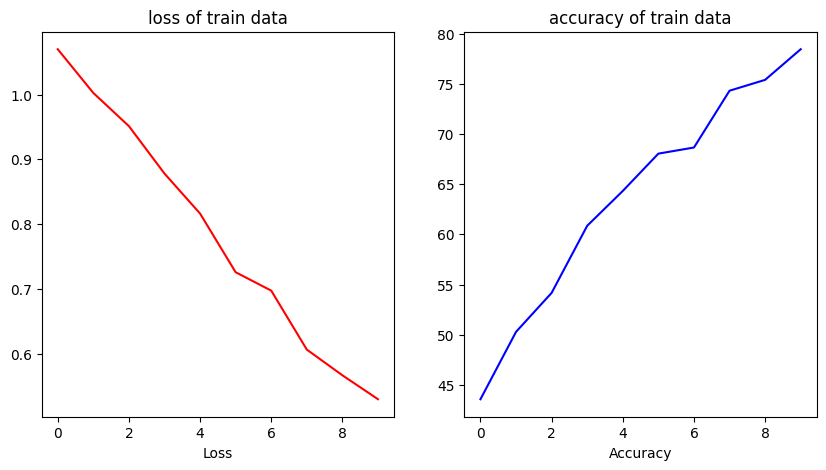

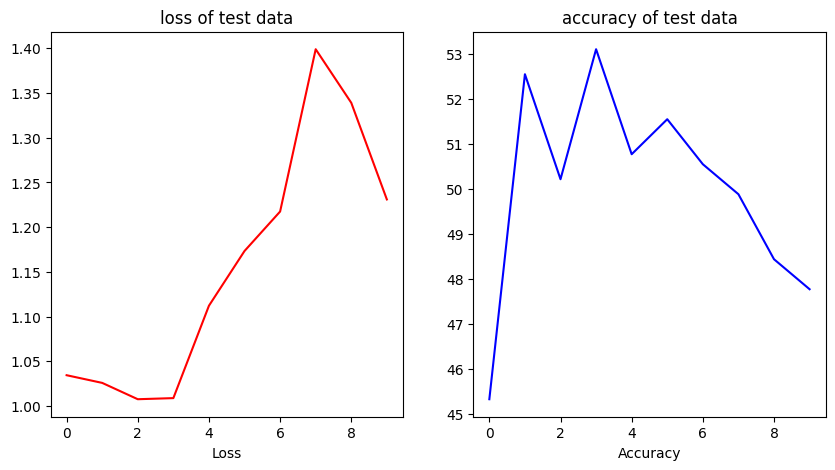

In [56]:
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train_eval(mlp, small_train_loader, small_test_loader, loss_fn, optimizer, 10)

show_loss_accuracy(train_loss_list, train_accuracy_list, title = "train data")

show_loss_accuracy(test_loss_list, test_accuracy_list, title = "test data")

**4. Save the trained model**

In [66]:
save_model(mlp, PATH = './mlp.pth')

## Step 4 - Build a CNN model


**1. Build the CNN model**

In [75]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    """
    CNN architecture:
        2 Convolutional layers
        2 max-pooling layers
        4 Fully connected layers
    for the purpose of Image Classification into 3 layers
    """
    def __init__(self):
        super().__init__()
        # channel: 3 -> 6, kernel size = 5
        # Convolutional Layers with Input & Output channels and Kernel sizes
        self.conv1 = nn.Conv2d(3,6,5)
        # 1/2 image size
        # maxpool: to reduce the spatial dimensions of the feature maps
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 45x82944 and 9*96*96x900
        self.fc1 = nn.Linear(9*96*96, 3*300)
        self.fc2 = nn.Linear(3*300, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 3) # 3 classes

    # how input data passes through the neural network layers
    def forward(self, x):
        x = self.maxpool1(F.relu(self.conv1(x))) 
        x = self.maxpool2(F.relu(self.conv2(x))) 
        
        # except batch, flatten all dimensions
        x = torch.flatten(x,1) 
        # Flatten data is passed through 
        # fully connected layers with 
        # Rectified Linear Unit activation functions
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [76]:
## Initialize the model, loss function, and optimizer
model = SimpleCNN()

# L2 Regularization (Weight Decay)
# default value of weight_decay = 0.0
#optimizer = optim.Adam(model.parameters(), lr=0.008, weight_decay=0.0)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [77]:
print(f'Simple CNN model: {model}')

Simple CNN model: SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=82944, out_features=900, bias=True)
  (fc2): Linear(in_features=900, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=3, bias=True)
)


**2. Train and Test the model**

Epoch 1 - Train Loss: 1.0980, Train Accuracy: 33.83, Test Loss: 1.0942, Test Accuracy: 33.22
Epoch 2 - Train Loss: 1.0907, Train Accuracy: 40.28, Test Loss: 1.0849, Test Accuracy: 45.78
Epoch 3 - Train Loss: 1.0790, Train Accuracy: 44.64, Test Loss: 1.0688, Test Accuracy: 46.11
Epoch 4 - Train Loss: 1.0580, Train Accuracy: 45.97, Test Loss: 1.0366, Test Accuracy: 49.00
Epoch 5 - Train Loss: 1.0213, Train Accuracy: 49.33, Test Loss: 1.0125, Test Accuracy: 51.22
Epoch 6 - Train Loss: 0.9745, Train Accuracy: 52.89, Test Loss: 1.0228, Test Accuracy: 49.56
Epoch 7 - Train Loss: 0.9528, Train Accuracy: 54.03, Test Loss: 0.9925, Test Accuracy: 53.22
Epoch 8 - Train Loss: 0.9216, Train Accuracy: 56.67, Test Loss: 1.0031, Test Accuracy: 52.56
Epoch 9 - Train Loss: 0.9152, Train Accuracy: 57.56, Test Loss: 1.0080, Test Accuracy: 52.22
Epoch 10 - Train Loss: 0.9001, Train Accuracy: 57.94, Test Loss: 1.0159, Test Accuracy: 52.11
Epoch 11 - Train Loss: 0.8772, Train Accuracy: 59.64, Test Loss: 1.04

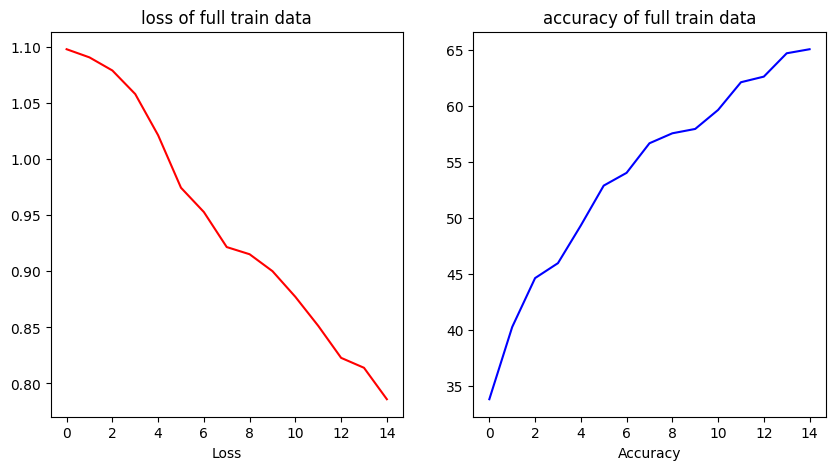

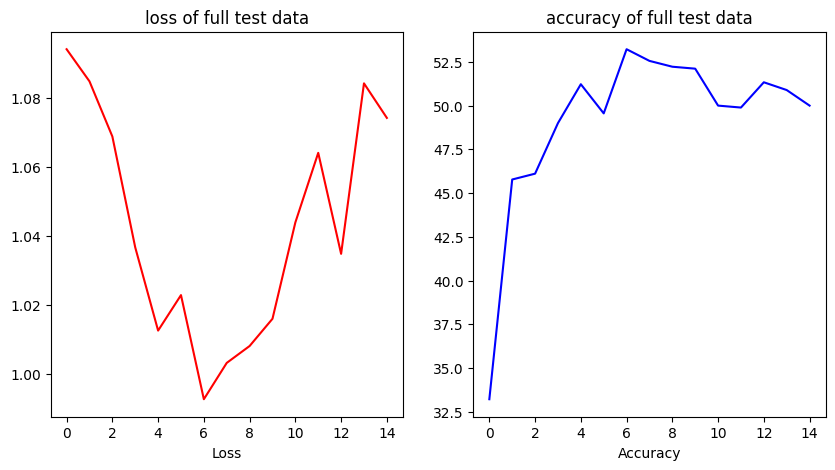

In [78]:
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train_eval(model, train_loader, test_loader, loss_fn, optimizer, 20)

show_loss_accuracy(train_loss_list, train_accuracy_list, title = "full train data")

show_loss_accuracy(test_loss_list, test_accuracy_list, title = "full test data")

**2. Save the trained model**

In [ ]:
save_model(model, PATH = './model.pth')

## Step 5 - Tuning the CNN model

**1. Get more data by augmentation**

In [137]:
folders = ['./traindata/cherry', './traindata/strawberry', './traindata/tomato']

for folder in folders:
    # Passing the path of the image directory
    p = Augmentor.Pipeline(folder)

    # Defining augmentation parameters and generating 5 samples
    p.flip_left_right(0.5)
    p.black_and_white(0.1)
    p.rotate(0.3, 10, 10)
    p.skew(0.4, 0.5)
    p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
    p.sample(300)
    
source_folders = ['./traindata/cherry/output', './traindata/strawberry/output', './traindata/tomato/output']

for index, src_folder in enumerate(source_folders):
    # List all files in the source directory
    files = os.listdir(src_folder)

    # Move each file to the destination directory
    for file in files:
        source_file_path = os.path.join(src_folder, file)
        destination_file_path = os.path.join(folders[index], file)
        shutil.move(source_file_path, destination_file_path)
        
    shutil.rmtree(src_folder)

Initialised with 2400 image(s) found.
Output directory set to ./traindata/cherry/output.

Processing <PIL.Image.Image image mode=RGB size=300x300 at 0x16392E2D0>: 100%|█|


Initialised with 2400 image(s) found.
Output directory set to ./traindata/strawberry/output.

Processing <PIL.Image.Image image mode=1 size=300x300 at 0x1634012D0>: 100%|█| 3


Initialised with 2400 image(s) found.
Output directory set to ./traindata/tomato/output.

Processing <PIL.Image.Image image mode=1 size=300x300 at 0x16377C6D0>: 100%|█| 3


**2. Split data**

Number of noisy images: 43


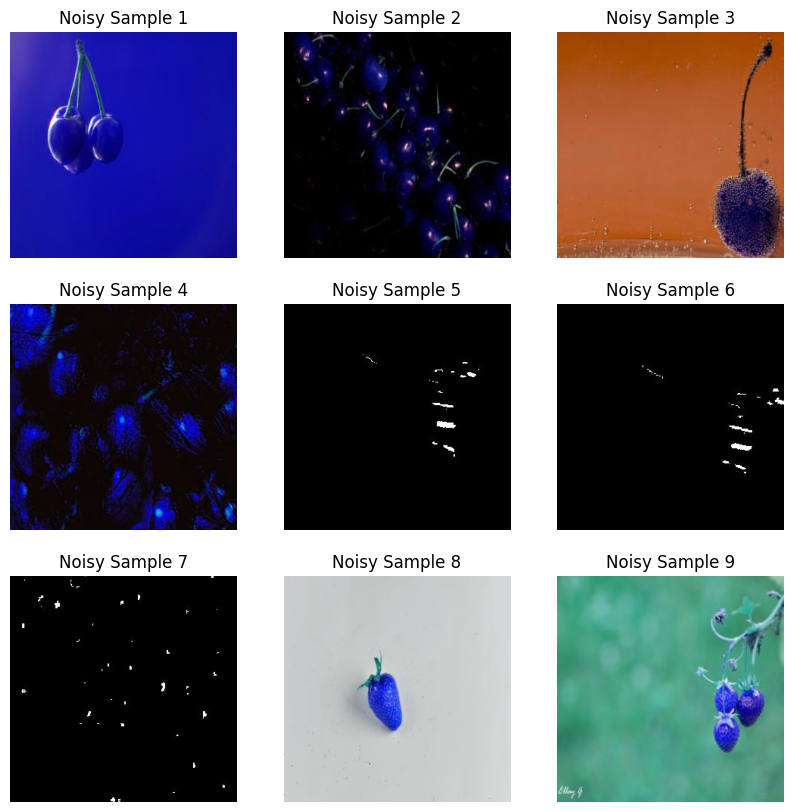

In [138]:
data_root = 'traindata'
custom_dataset = ImageFolder(root=data_root, transform=transforms.ToTensor())

noisy_image_count, noisy_images, non_noisy_images = detect_noisy_images(custom_dataset)

custom_dataset.transform = transform_train
custom_dataset.imgs = non_noisy_images

train, test, train_loader, test_loader = prepare_train_test_data(custom_dataset)

------------------------
Class distribution:
cherry: 2403 samples
strawberry: 2310 samples
tomato: 2147 samples


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


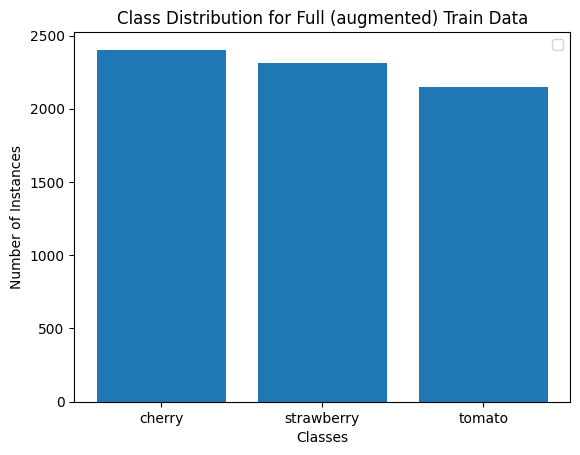

------------------------
Class distribution:
cherry: 597 samples
strawberry: 566 samples
tomato: 553 samples


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


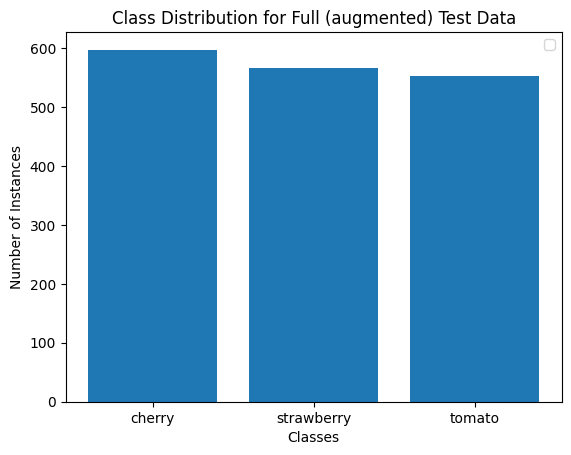

In [139]:
show_class_distribution(train, 'Class Distribution for Full (augmented) Train Data')    
show_class_distribution(test, 'Class Distribution for Full (augmented) Test Data')    

**3. Finetuning by ResNet50**

In [ ]:
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler
import time
import os

## 1. Transfer Learning
model_ft = models.resnet18(weights='IMAGENET1K_V1')
input_features = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(input_features, len(classes))

## 2. Loss function
loss_fn = nn.CrossEntropyLoss()

## 3. Optimization method
## 4. L2 Regularization (Weight Decay)
optimizer = optim.Adam(model_ft.parameters(), lr=0.008, weight_decay=0.001)

## 5. Hyper-parameter settings - increase Epoch to 25
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train_eval(
    model_ft, train_loader, test_loader, loss_fn, optimizer, 25
)

Epoch 1 - Train Loss: 1.1988, Train Accuracy: 37.51, Test Loss: 1.2071, Test Accuracy: 41.78
Epoch 2 - Train Loss: 1.0662, Train Accuracy: 45.47, Test Loss: 1.0564, Test Accuracy: 41.61
Epoch 3 - Train Loss: 1.0162, Train Accuracy: 47.89, Test Loss: 1.0373, Test Accuracy: 45.92
Epoch 4 - Train Loss: 0.9924, Train Accuracy: 48.97, Test Loss: 1.3371, Test Accuracy: 50.12
Epoch 5 - Train Loss: 0.9994, Train Accuracy: 49.59, Test Loss: 1.3366, Test Accuracy: 36.13
Epoch 6 - Train Loss: 0.9840, Train Accuracy: 50.67, Test Loss: 1.1297, Test Accuracy: 32.34
Epoch 7 - Train Loss: 0.9727, Train Accuracy: 51.91, Test Loss: 1.1265, Test Accuracy: 36.83
Epoch 8 - Train Loss: 0.9752, Train Accuracy: 51.38, Test Loss: 1.1397, Test Accuracy: 40.62
Epoch 9 - Train Loss: 0.9498, Train Accuracy: 53.76, Test Loss: 1.6765, Test Accuracy: 32.17
Epoch 10 - Train Loss: 0.9539, Train Accuracy: 54.07, Test Loss: 0.9735, Test Accuracy: 51.75
Epoch 11 - Train Loss: 0.9441, Train Accuracy: 54.02, Test Loss: 1.66

In [ ]:
show_loss_accuracy(train_loss_list, train_accuracy_list, title = "train data")

show_loss_accuracy(test_loss_list, test_accuracy_list, title = "test data")

**2. Save model**

In [ ]:
save_model(model_ft, PATH = './model_ft.pth')

In [ ]:
save_model(model, PATH = './model.pth')